<a href="https://colab.research.google.com/github/JShyam33/Evolutionary-algorithm/blob/master/Evolution_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
refrences 

1) https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html

2) https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.ndarray.flatten.html

3) https://towardsdatascience.com/evolving-neural-networks-b24517bb3701



'''

In [0]:
import copy
import numpy as np
class Organism():
    def __init__(self, dimensions, use_bias=True, output='softmax'):
        self.layers = []
        self.biases = []
        self.use_bias = use_bias
        self.output = self._activation(output)
        for i in range(len(dimensions)-1):
            shape = (dimensions[i], dimensions[i+1])
            std = np.sqrt(2 / sum(shape))
            layer = np.random.normal(0, std, shape)
            bias = np.random.normal(0, std, (1,  dimensions[i+1])) * use_bias
            self.layers.append(layer)
            self.biases.append(bias)

    def _activation(self, output):
        if output == 'softmax':
            return lambda X : np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1, 1)
        if output == 'sigmoid':
            return lambda X : (1 / (1 + np.exp(-X)))
        if output == 'linear':
            return lambda X : X

    def predict(self, X):
        if not X.ndim == 2:
            raise ValueError(f'Input has {X.ndim} dimensions, expected 2')
        if not X.shape[1] == self.layers[0].shape[0]:
            raise ValueError(f'Input has {X.shape[1]} features, expected {self.layers[0].shape[0]}')
        for index, (layer, bias) in enumerate(zip(self.layers, self.biases)):
            X = X @ layer + np.ones((X.shape[0], 1)) @ bias
            if index == len(self.layers) - 1:
                X = self.output(X) # output activation
            else:
                X = np.clip(X, 0, np.inf)  # ReLU
        return X
    def mate(self, other, mutate=True):
        if self.use_bias != other.use_bias:
            raise ValueError('Both parents must use bias or not use bias')
        if not len(self.layers) == len(other.layers):
            raise ValueError('Both parents must have same number of layers')
        if not all(self.layers[x].shape == other.layers[x].shape for x in range(len(self.layers))):
            raise ValueError('Both parents must have same shape')

        child = copy.deepcopy(self)
        for i in range(len(child.layers)):
            pass_on = np.random.rand(1, child.layers[i].shape[1]) < 0.5
            child.layers[i] = pass_on * self.layers[i] + ~pass_on * other.layers[i]
            child.biases[i] = pass_on * self.biases[i] + ~pass_on * other.biases[i]
        if mutate:
            child.mutate()
        return child
    def mutate(self, stdev=0.03):
        for i in range(len(self.layers)):
            self.layers[i] += np.random.normal(0, stdev, self.layers[i].shape)
            if self.use_bias:
                self.biases[i] += np.random.normal(0, stdev, self.biases[i].shape)

In [0]:
class Ecosystem():
  def __init__(self,original_f,scoring_function,population_size=100,holdout='sqrt',mating=True):
    self.population_size = population_size
    self.population = [original_f() for _ in range(population_size)]

    self.scoring_function = scoring_function

    if holdout == 'sqrt':
      self.holdout = max(1, int(np.sqrt(population_size)))
    elif holdout == 'log':
      self.holdout = max(1, int(np.log(population_size)))
    elif holdout > 0 and holdout < 1:
      self.holdout = max(1, int(holdout * population_size))
    else:
      self.holdout = max(1, int(holdout))

    self.mating = mating

  
  def generation(self,repeats= 1,keep_best = True):
    rewards = [np.mean([self.scoring_function(x) for _ in range(repeats)]) for x in tqdm(self.population)]
    self.population = [self.population[x] for x in np.argsort(rewards)[::-1]]

    new_population = []

    for i in range(self.population_size):
      parent_1_idx = i % self.holdout
      if self.mating:
        parent_2_idx = min(self.population_size - 1, int(np.random.exponential(self.holdout)))
      else:
        parent_2_idx = parent_1_idx
      
      offspring = self.population[parent_1_idx].mate(self.population[parent_2_idx])

      new_population.append(offspring)
    
    self.population = new_population
  

  def get_best_organism(self,include_rewards =  False):
    rewards = [self.scoring_function(x) for x in self.population ]

    if include_rewards:
      best = np.argsort(rewards)[-1]
      return self.population[best] , rewards[best]
    else:
      return self.population[np.argsort(rewards)[-1]]

0 : -0.34
10 : -0.17
20 : -0.13
30 : -0.11
40 : -0.09
50 : -0.06
60 : -0.04
70 : -0.02
80 : -0.02
90 : -0.02
100 : -0.02
110 : -0.02
120 : -0.01
130 : -0.01
140 : -0.01
150 : -0.02
160 : -0.01
170 : -0.01
180 : -0.01
190 : -0.02
200 : -0.02


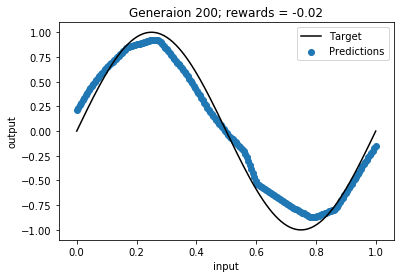

In [0]:
def main():
  import matplotlib.pyplot as plt



  organism_creator = lambda : Organism([1,16,16,16,1],output='linear',use_bias = True)

  true_function = lambda x: np.sin(2 * np.pi * x)

  loss_function = lambda y_true, y_pred : np.mean((y_true-y_pred)**2)
  x = np.linspace(0,1,200)
  def simulate_and_evalulate(organism, replicates=1):
    X = np.random.random((replicates, 1))
    predictions = organism.predict(X)
    loss = loss_function(true_function(X),predictions)

    return -loss

  scoring_function = lambda organism: simulate_and_evalulate(organism, replicates=500)

  ecosystem  = Ecosystem(organism_creator,scoring_function,population_size=100,holdout= 0.1,mating = True)


  best_organism = [ecosystem.get_best_organism()]

  generations = 201



  for i in range(generations):
    ecosystem.generation()
    this_generation_best = ecosystem.get_best_organism(include_rewards=True)
    best_organism.append(this_generation_best[0])

    if i % 10 == 0:
      print(f'{i} : {this_generation_best[1]:.2f}')
    if i % 10 == 0 and False:
      plt.scatter(X,best_organism[-1].predict(X.reshape(-1,1)).flatten(),label='predictions')

      plt.plot(X,true_function(X),label='Target', c='k')

      plt.legend()

      plt.title(f'Generaion {i}; rewards = {this_generation_best[1]:.2f}')
      plt.xlabel('input')
      plt.ylabel('output')

      plt.show()
  
  plt.scatter(x, best_organism[-1].predict(x.reshape(-1,1)).flatten(),label='Predictions')
  plt.plot(x,true_function(x),label='Target', c='k')

  plt.legend()

  plt.title(f'Generaion {i}; rewards = {this_generation_best[1]:.2f}')
  plt.xlabel('input')
  plt.ylabel('output')
  plt.show()

if __name__ == '__main__':
  main()


Using evolutionary approach on MNIST data set

In [0]:
import keras
from keras.datasets import mnist
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from keras.models import Sequential
from keras import backend as K
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
batch_size = 128
num_classes = 10
epochs = 12

im_row , im_cols = (28,28)

(x_train,y_train) , (x_test,y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, im_row, im_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, im_row, im_cols)
    input_shape = (1, im_row, im_cols)
else: 
    x_train = x_train.reshape(x_train.shape[0], im_row, im_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], im_row, im_cols, 1)
    input_shape = (im_row, im_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

11493376/11490434 [==============================] - 1s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
#model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [0]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 60000 samples, validate on 10000 samples
Epoch 1/12





60000/60000 [==============================] - 149s 2ms/step - loss: 0.3375 - acc: 0.9037 - val_loss: 0.0588 - val_acc: 0.9815
Epoch 2/12
60000/60000 [==============================] - 148s 2ms/step - loss: 0.0941 - acc: 0.9721 - val_loss: 0.0411 - val_acc: 0.9863
Epoch 3/12
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0717 - acc: 0.9786 - val_loss: 0.0335 - val_acc: 0.9888
Epoch 4/12
60000/60000 [==============================] - 148s 2ms/step - loss: 0.0571 - acc: 0.9830 - val_loss: 0.0310 - val_acc: 0.9901
Epoch 5/12
60000/60000 [==============================] - 148s 2ms/step - loss: 0.0502 - acc: 0.9848 - val_loss: 0.0290 - val_acc: 0.9914
Epoch 6/12
60000/60000 [==============================] - 149s 2ms/step - loss: 0.0442 - acc: 0.9865 - val_loss: 0.0279 - val_acc: 0.9912
Epoch 7/12
60000/600

In [0]:
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

Traceback (most recent call last):
  File "/usr/local/bin/jupyter", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/command.py", line 230, in main
    command = _jupyter_abspath(subcommand)
  File "/usr/local/lib/python2.7/dist-packages/jupyter_core/command.py", line 133, in _jupyter_abspath
    'Jupyter command `{}` not found.'.format(jupyter_subcommand)
Exception: Jupyter command `jupyter-labextension` not found.


In [0]:
%%capture
from tqdm import tqdm_notebook as tqdm


In [0]:
import sys, math
class Organism_mnist():
  def __init__(self,layers,output='softmax'):
    self.layers = []
    self.output = self._activation(output)
    
    for layer in layers:
      struct_layer = dict()
      struct_layer = layer
      struct_layer['name'] = layer['name']
      shape = layer['shape']
      if layer['name'] != 'Dense' and layer['name'] != 'conv2d':
        self.layers.append(struct_layer)
        continue
      

      std = np.sqrt(2 / sum(shape))
      layer_weights = np.random.normal(0, std, shape)
      struct_layer['weights'] = layer_weights
      self.layers.append(struct_layer)
      
  def _activation(self, output):
        if output == 'softmax':
          
            def softmax(z):
              z_exp = [np.exp(i) for i in z]
              sum_z_exp = sum(z_exp)
              return [i / sum_z_exp for i in z_exp]
            return lambda X : softmax(X)
        if output == 'sigmoid':
            return lambda X : (1 / (1 + np.exp(-X)))
        if output == 'linear':
            return lambda X : X
  def predict(self, x):
    layers = self.layers
    o = []
    for j in x: 
      
      res = j
      for i in range(len(self.layers)):
        if layers[i]['name'] == 'conv2d':
            
            j = self.conv(j,layers[i]['weights'])
            
        elif layers[i]['name'] == 'Flatten':
          j = j.flatten()
          
        elif layers[i]['name'] == 'Dense':

          j = j @ layers[i]['weights'] 
          
        elif layers[i]['name'] == 'sigmoid':

          j = 1 / (1 + np.exp(j))
          
        elif layers[i]['name'] == 'max_pool':
          j = self.max_pool(j)
          
        elif layers[i]['name'] == 'softmax':
          
          j = np.array(j,dtype=np.float128)
          
          j = self.output(j)
           # output activation
          
        else:
          j = np.clip(j, 0, np.inf)  # ReLU
          
      o.append(j)
    return o
  
  def max_pool(self,img):
    feature_maps = np.zeros((int((img.shape[0] -2 +1) / 2 ), int((img.shape[1] -2 + 1) / 2) , img.shape[2]))
    pool_size = 2
    for ch_num in range(img.shape[2]):
      r2 = 0
      for r in range(0,img.shape[0] - 2 -1 ,2):
        c2 = 0
        for c in range(0,img.shape[1] - 2- 1,2):
          feature_maps[r2,c2,ch_num] = np.max(img[r:r+pool_size,c:c+pool_size])
          c2 = c2 + 1
        r2 = r2 + 1
      
    return feature_maps

  def conv(self,img, conv_filter):  
    
    '''if len(img.shape) > 2 or len(conv_filter.shape) > 3:
      if img.shape[-1] != conv_filter.shape[-1]:  
        print("Error: Number of channels in both image and filter must match. image = ",img.shape[-1],"convule shape = ",conv_filter.shape[-1])  
        
    if conv_filter.shape[0] != conv_filter.shape[1]: # Check if filter dimensions are equal.  
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match. row = ',conv_filter.shape[1]," col = ",conv_filter.shape[2])  
        
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.  
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')  '''
        
   
    # An empty feature map to hold the output of convolving the filter(s) with the image.  
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1,   
                                img.shape[1]-conv_filter.shape[1]+1,   
                                 conv_filter.shape[0]))  
   
     # Convolving the image by the filter(s).  
    for n_filter in range(conv_filter.shape[0]):

      curr_filter =  conv_filter[n_filter,:,:]
      if len(img.shape) > 2:
        conv_map = self.conv_(img[:,:,0],curr_filter)
        for ch_num in range(1 , img.shape[-1]):
          conv_map = conv_map + self.conv_(img[:,:,ch_num],curr_filter)  
      else:
        conv_map = self.conv_(img, curr_filter)  
        
      feature_maps[:,:,n_filter] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

  def conv_(self,img, conv_filter):  
      filter_size = conv_filter.shape[0]  
      result = np.zeros((img.shape))
      
      #Looping through the image to apply the convolution operation.  
      for r in np.uint16(np.arange(filter_size/2,   
                            img.shape[0]-filter_size/2-2)):  
          for c in np.uint16(np.arange(filter_size/2, img.shape[1]-filter_size/2-2)):  
              #Getting the current region to get multiplied with the filter.  
             curr_region = img[r:r+filter_size, c:c+filter_size]  
             #Element-wise multipliplication between the current region and the filter.  
             curr_result = curr_region * conv_filter  
             conv_sum = np.sum(curr_result) #Summing the result of multiplication.  
             result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.  
               
      #Clipping the outliers of the result matrix.
        
      final_result = result[np.uint16(filter_size/2):result.shape[0]-np.uint16(filter_size/2),   
                          np.uint16(filter_size/2):result.shape[1]-np.uint16(filter_size/2)]  
      final_result  = np.array(final_result)
      final_result = np.reshape(final_result,(final_result.shape[0],final_result.shape[1]))
      return final_result  

  def mate(self, other, mutate=True):
        
        child = copy.deepcopy(self)
        for i in range(len(child.layers)):
          if self.layers[i]['name'] != 'Dense' and self.layers[i]['name'] != 'conv2d':
            continue
          pass_on = np.random.rand(1, child.layers[i]['weights'].shape[1]) < 0.5
          child.layers[i]['weights'] = pass_on * self.layers[i]['weights'] + ~pass_on * other.layers[i]['weights']
        if mutate:
            child.mutate()
        return child
  def mutate(self, stdev=0.03):
    for i in range(len(self.layers)):
      if self.layers[i]['name'] != 'Dense' and self.layers[i]['name'] != 'conv2d':
        continue
      self.layers[i]['weights'] += np.random.normal(0, stdev, self.layers[i]['weights'].shape)



In [0]:
np.arange(24,10)

array([], dtype=int64)

In [0]:
l1_filter = np.array([[[-1,0,1],
                                  [-1,0,1],
                                  [-1,0,1]]])
l1_filter = np.reshape(l1_filter,(3,3,1))



network = [
           {
              'name':'conv2d',
              'shape':(12,3,3),
              
          },
          {
              'name':'relu',
              'shape':()
          },
          {
              'name':'max_pool',
              'shape':()
          },
          {
              'name':'conv2d',     
              'shape':(24,3,3),
              
          },
          {
              'name':'relu',
              'shape':()
          },
          {
              'name':'max_pool',
              'shape':()
          },
          {
              'name':'Flatten',
              'shape':()
          },
          {
              'name':'Dense',
              'shape':(384,128)
          },
          {
              'name':'relu',
              'shape':()
          },
          {
              'name':'Dense',
              'shape':(128,10)
          },
          {
              'name' : 'softmax',
              'shape':()
          }
]

organism_creator = lambda : Organism_mnist(network,output='softmax')
fitness_function = lambda y_true, y_estimate : (accuracy_score(np.argmax(y_true,axis=1),np.argmax(y_estimate, axis=1)))

def simulate_and_evaluate(organism, indices):
    """
    Predict the probabilities of each class and return the fitness
    Indices is the list of indices to use in evaluation
    """
    predictions = organism.predict(indices)
    
    return fitness_function(train_data_y, predictions)
scoring_function = lambda organism : simulate_and_evaluate(organism, indices=train_data_x)
ecosystem = Ecosystem(organism_creator, scoring_function, population_size=50, holdout=0.1, mating=True)
generations = 50
for i in tqdm(range(generations)):
    ecosystem.generation()
    this_generation_best = ecosystem.get_best_organism(include_rewards=True)
    if i % 10 == 0:
      print(f'{i} : {this_generation_best[1]:.2f}')


0 : 0.20


10 : 0.40


In [0]:
26/2

13.0

In [0]:
train_data_x = []
train_data_y = []
for i in range(10):
  train_data_x.append(x_train[np.argmax(y_train,axis=1) == i][0])
  train_data_y.append(y_train[np.argmax(y_train,axis=1) == i][0])
train_data_x = np.array(train_data_x)
train_data_y = np.array(train_data_y)
print(train_data_x.shape)
print(train_data_y.shape)

(10, 28, 28, 1)
(10, 10)


In [0]:
print(np.argmax(train_data_y,axis=1))

[0 1 2 3 4 5 6 7 8 9]
